# U-Net Arquitectura Básica

Vamos a constuir una arquitecutra U-Net básica (con y sin dropout) para realizar segmentación semántica del dataset Electron Microscopy Dataset que contiene imágenes tomadas del hipocampo CA1 de secciones del cerebro de 5x5x5um dónde se han obtenido mascaras de las mitocondrias. Usaremos U-net para realizar la segmentación semántica, contruiremos un modelo básico, y luego una modificación con Dropout. El tamaño de las imágenes de entrada será 128x128.

[Enlace Dataset](https://www.epfl.ch/labs/cvlab/data/data-em/)

[Paper Original](https://arxiv.org/pdf/1505.04597.pdf)

## 1. Importamos librerías

In [1]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

## 2. Definimos configuración básica

In [2]:
width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 20
data_path_train = "stage1_train/"    # Directorio de las imágenes y mascaras de entrenamiento
data_path_test = "stage1_test/"      # Directorio de las imágenes de pruebas

## 3. Adecuamos el dataset

In [7]:
# obtenemos una lista con los archivos dentro de cada carpeta
data_list_train = os.listdir(data_path_train)
data_list_test = os.listdir(data_path_test)

# Definimos listas para guardar cada elemento del dataset
Xtrain=[] 
Ytrain=[]
Xtest=[]

# Recorremos la carpeta train
for folder in tqdm(data_list_train):
    # leemos cada imagen del dataset de entrenamiento y la redimensionamos
    img = imread(data_path_train +folder+ '/images/'  + folder+'.png')[:,:,:3]  
    img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
    # Agregamos cada imagen a la lista Xtrain
    Xtrain.append(img)
    
    # Creamos una mascarar de zeros 
    mask = np.zeros((height_shape, width_shape, 1), dtype=np.bool)
    # Guardamos en una lista todos los archivos en el directorio masks de entrenamiento
    data_list_mask = os.listdir(data_path_train+folder+'/masks/')
    # Recorremos todos los archivos dentro del directorio de masks
    for name_file in data_list_mask:
        # Leemos cada una de las mascaras binarias y las redimensionamos
        maskt = imread(data_path_train +folder+ '/masks/'  + name_file) 
        maskt = resize(maskt, (height_shape, width_shape),mode='constant', preserve_range=True)
        maskt = np.expand_dims(maskt, axis=-1)
        # Unimos la mascara actual con la anterior (equivalente a una operación OR)
        mask = np.maximum(mask, maskt) 
    
    # Agregamos cada mascara a la lista Ytrain
    Ytrain.append(mask)

# Recorremos la carpeta test
for folder in tqdm(data_list_test):
    # leemos cada imagen del dataset de prueba y la redimensionamos
    img = imread(data_path_test +folder+ '/images/'  + folder+'.png')[:,:,:3]  
    img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
    # Agregamos cada imagen a la lista Xtest
    Xtest.append(img)
    
X_train = np.asarray(Xtrain,dtype=np.uint8)
print('Xtrain:',X_train.shape)

Y_train = np.asarray(Ytrain,dtype=np.bool)
print('Ytrain:',Y_train.shape)

X_test = np.asarray(Xtest,dtype=np.uint8)
print('Xtest:',X_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 19.57it/s]

Xtrain: (670, 128, 128, 3)
Ytrain: (670, 128, 128, 1)
Xtest: (65, 128, 128, 3)


## 4. Mostramos algún elemento del dataset

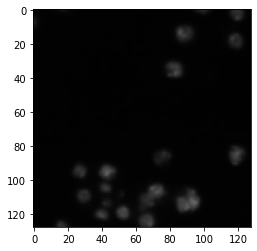

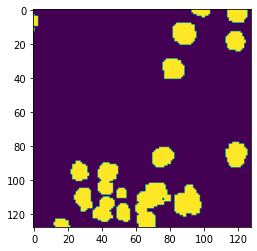

In [8]:
# Mostramos la imagen y su mascara asociada
plt.imshow(X_train[0])
plt.show()
plt.imshow(np.squeeze(Y_train[0]))
plt.show()

## 5. Creamos un modelo básico de U-Net

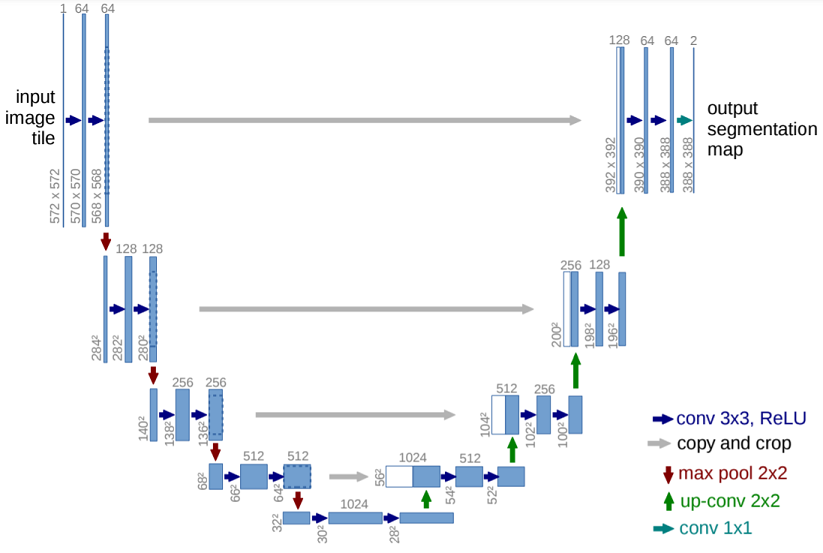

In [9]:
# Definimos la entrada al modelo
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 64) 1792        lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_38[0][0]                  
____________________________________________________________________________________________

## 6. Creamos un modelo U-Net con Dropout

In [ ]:
# Definimos la entrada al modelo

inputs = Lambda(lambda x: x / 255)(Input((height_shape, width_shape, 3)))

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Dropout(0.1)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Dropout(0.1)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Dropout(0.1)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## 7. Configuramos Tensorboard

In [10]:
from tensorflow.keras.callbacks import TensorBoard

# Cargamos la extensión, definimos la carpeta logs para guardar los datos de entrenamiento, y definimos el callback
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 8. Entrenamos el modelo

In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 48s 79ms/sample - loss: 0.8499 - accuracy: 0.7821 - val_loss: 0.5429 - val_accuracy: 0.8162
Epoch 2/20
603/603 [==============================] - 29s 48ms/sample - loss: 0.3965 - accuracy: 0.8305 - val_loss: 0.2337 - val_accuracy: 0.9148
Epoch 3/20
603/603 [==============================] - 29s 47ms/sample - loss: 0.3191 - accuracy: 0.8713 - val_loss: 0.2972 - val_accuracy: 0.8878
Epoch 4/20
603/603 [==============================] - 29s 48ms/sample - loss: 0.2668 - accuracy: 0.8804 - val_loss: 0.1854 - val_accuracy: 0.9274
Epoch 5/20
603/603 [==============================] - 29s 48ms/sample - loss: 0.1914 - accuracy: 0.9211 - val_loss: 0.1850 - val_accuracy: 0.9299
Epoch 6/20
603/603 [==============================] - 29s 48ms/sample - loss: 0.1559 - accuracy: 0.9382 - val_loss: 0.1229 - val_accuracy: 0.9530
Epoch 7/20
603/603 [==============================] - 29s 49ms/sample - loss: 0

## 9. Revisamos gráficas de entrenamiento

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --host localhost

## 10. Probamos el modelo con alguna imagen de prueba

In [ ]:
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[1]))
plt.show()
plt.imshow(X_test[1])
plt.show()